# Vehicle Routing Problem
## Initialization

In [1]:
import numpy as np
import utility

from full_qubo_solver import FullQuboSolver
from average_partition_solver import AveragePartitionSolver
from qiskit_native_solver import QiskitNativeSolver
from route_activation_solver import RouteActivationSolver

In [2]:
n = 5
m = 2
seed = 1543

In [3]:
instance, xc, yc = utility.generate_vrp_instance(n, seed)

In [4]:
vrp1 = FullQuboSolver(n, m, instance)
vrp2 = AveragePartitionSolver(n, m, instance)
vrp3 = RouteActivationSolver(n, m, instance)
vrp4 = QiskitNativeSolver(n, m, instance)

## Solve via Hybrid Solvers

In [5]:
vrp_list = [vrp1, vrp2, vrp3, vrp4]
for vrp in vrp_list:
    vrp.solve(solver='hybrid')

## Full Qubo Solver (FQS)

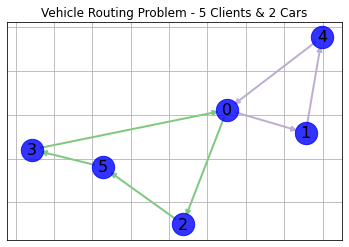

In [6]:
vrp1.visualize(xc, yc)

## Average Partitioning Solver (APS)

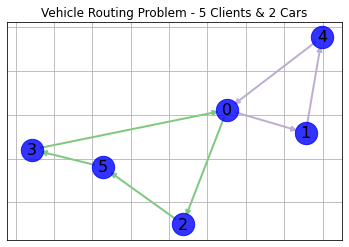

In [7]:
vrp2.visualize(xc, yc)

## Route Activation Solver (RAS)

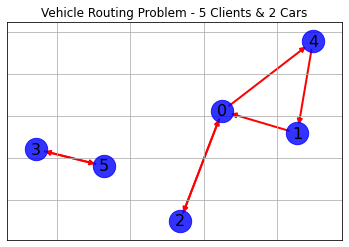

In [8]:
vrp3.visualize(xc, yc)

## Qiskit Native Solver (QNS)

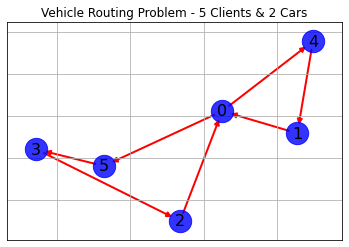

In [9]:
vrp4.visualize(xc, yc)

## Cost Comparison

In [10]:
solver_types = ['FQS', 'APS', 'RAS', 'QNS']
for i, vrp in enumerate(vrp_list):
    print(f'{solver_types[i]} - Optimized Cost: {vrp.result.first.energy}')

FQS - Optimized Cost: 16.7325143153339
APS - Optimized Cost: 16.7325143153339
RAS - Optimized Cost: 13.045042357055081
QNS - Optimized Cost: 16.768674972698136
